# **Custom Datasets**





### **1. Imports**

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.3.0+cu121


Setup device-agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### **2. Get Data**

In [3]:
import requests
import zipfile
from pathlib import Path

# Step 1: Set up the path
url = "https://github.com/mohd-faizy/PyTorch-Essentials/raw/main/_datasets/pizza_steak_sushi.zip"
image_path = Path("data/pizza_steak_sushi")
image_path.mkdir(parents=True, exist_ok=True)
zip_path = image_path.parent / "pizza_steak_sushi.zip"

# Step 2: Download the zip file containing the data
zip_path.write_bytes(requests.get(url).content)

# Step 3: Unzip the downloaded file into the image directory
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(image_path)

### **3.Data Preparation and Data Exploration**

In [4]:
image_path

PosixPath('data/pizza_steak_sushi')

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### **4. Visualizing the Data**

Random Image path: data/pizza_steak_sushi/train/pizza/2760984.jpg
Image class: pizza
height x width: 512 x 512


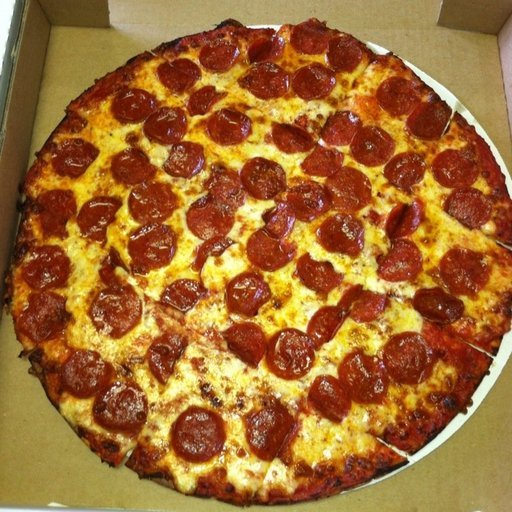

In [7]:
import random
from PIL import Image # Python Imaging Library

## set seed
# random.seed(42)

# 1. get all images path
# Use glob to find all .jpg images in subdirectories (two levels deep)
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
# Randomly select one image path from the list of all image paths
random_image_path = random.choice(image_path_list)

# 3. Get image class from the path name
# The image class in the name of the directory where the image is stored
image_class = random_image_path.parent.stem

# 4. Open image
# Open the image using Pillow's Image class
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"height x width: {img.height} x {img.width}")
img

### **5. `Image To Array`** **HWC**

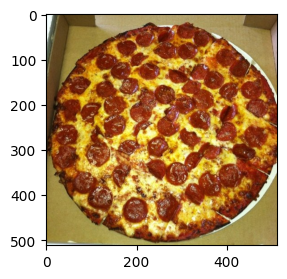

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image to array
img_array = np.array(img)

# plot image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_array);

In [9]:
print(f"{img_array.shape} -> height, width, color channels")
print(f"{img_array.ndim}")

(512, 512, 3) -> height, width, color channels
3


array([[[245, 254, 253],
        [245, 254, 253],
        [245, 254, 253],
        ...,
        [110,  83,  53],
        [112,  85,  55],
        [113,  86,  56]],

       [[245, 254, 253],
        [245, 254, 253],
        [245, 254, 253],
        ...,
        [108,  81,  51],
        [110,  83,  53],
        [111,  84,  54]],

       [[245, 254, 253],
        [245, 254, 253],
        [245, 254, 253],
        ...,
        [105,  78,  48],
        [106,  79,  49],
        [107,  80,  50]],

       ...,

       [[217, 228, 220],
        [216, 227, 219],
        [215, 226, 220],
        ...,
        [167, 143,  95],
        [167, 144,  94],
        [168, 145,  95]],

       [[227, 242, 239],
        [227, 242, 239],
        [226, 240, 240],
        ...,
        [169, 145,  97],
        [168, 145,  95],
        [169, 146,  96]],

       [[224, 240, 239],
        [224, 240, 239],
        [224, 240, 240],
        ...,
        [170, 146,  98],
        [169, 146,  96],
        [168, 145,  95]]], dtype=uint8)
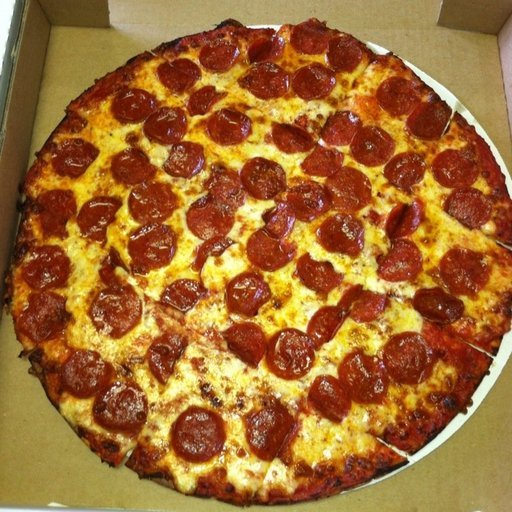

In [10]:
img_array

### **6. Transforming data** (`Image To Tensor`) **CHW**

- Numerical representation of our images

- Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

- Transforms help you get your images ready to be used with a model/perform data augmentation - [**PyTorch Transform**](https://pytorch.org/vision/stable/transforms.html)

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

```python
from torchvision.transforms import ToTensor
```

In [12]:
data_transform = transforms.Compose([         # Write a transform for image
    transforms.Resize(size=(64, 64)),         # Resize our images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),   # Flip the images randomly on the horizontal ~ prob 50% i.e img transfrom 50% of time
    transforms.ToTensor()                     # Turn the image into a torch.Tensor
])

In [13]:
data_transform(img).shape, data_transform(img).dtype # CHW

(torch.Size([3, 64, 64]), torch.float32)

**Note:** `PyTorch` transform our image to color channel first `[3, 64, 64]`, while `Matplotlib` prefer color channel last `[64, 64, 3]`.




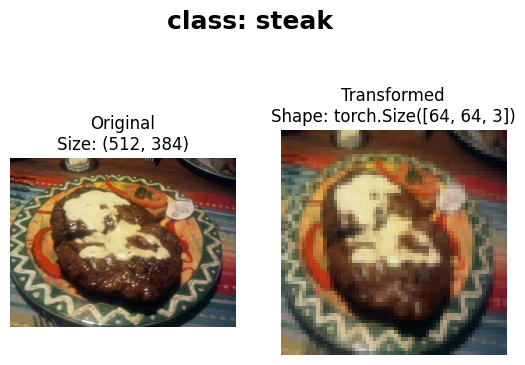

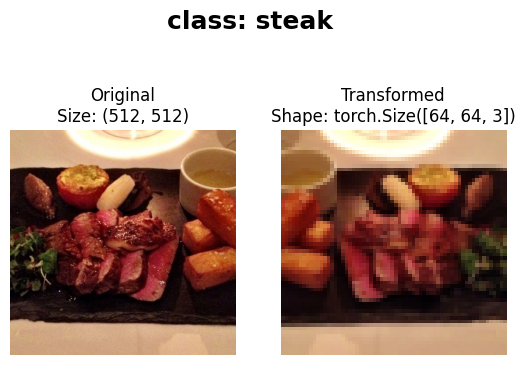

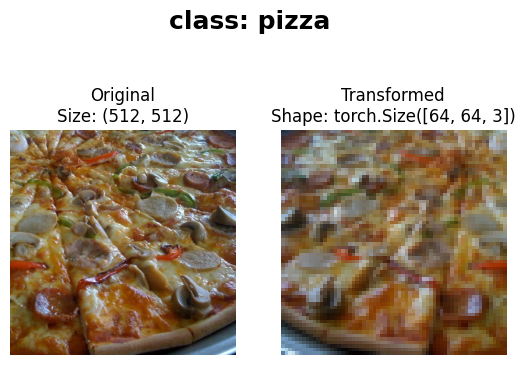

In [14]:
def plot_transformed_images(image_path:list, transform, n=3, seed=None):
    """
    This function takes a list of image paths, applies the specified transformation,
    and plots the original and transformed versions side by side. The seed parameter
    allows for reproducible random sampling. You can use this function by passing
    your own image_path_list and data_transform.

    Args:
        `image_paths` (list): A list of image file paths.
        `transform`: An image transformation function (e.g., rotation, scaling, etc.).
        `n` (int, optional): The number of images to select (default is 3).
        `seed` (int, optional): Random seed for reproducibility (default is None).

    Returns:
        None (plots the images)

    Example usage:
        plot_transformed_images(image_paths=image_path_list,
                                transform=data_transform,
                                n=3,
                                seed=None)
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original Image
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"class: {image_path.parent.stem}", fontsize=18, weight='bold')


plot_transformed_images(image_path=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

### **7. Loading Dataset ~ `Option-1`**

#### Loading Image Data using **Pytorch** `ImageFolder`

**Note:** The `ImageFolder` class in PyTorch expects the images to be arranged in a specific folder structure by default. Here’s how it should be organized:


```
my_dataset/
    ├──train/
    │   ├── cats/
    │   │   ├── cat1.jpg
    │   │   ├── cat2.jpg
    │   │   └── ...
    │   ├── dogs/
    │   │   ├── dog1.jpg
    │   │   ├── dog2.jpg
    │   │   └── ...
    │   └── birds/
    │        ├── bird1.jpg
    │        ├── bird2.jpg
    │        └── ...
    └──test/    
        ├── cats/
        │   ├── cat1.jpg
        │   ├── cat2.jpg
        │   └── ...
        ├── dogs/
        │   ├── dog1.jpg
        │   ├── dog2.jpg
        │   └── ...
        └── birds/
            ├── bird1.jpg
            ├── bird2.jpg
            └── ...
```

#### 7.1 `ImageFolder`

```python
from torchvision.datasets import ImageFolder
```

In [15]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [16]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                         transform=data_transform,
                         target_transform=None)

test_data = ImageFolder(root=test_dir,
                        transform=data_transform,
                        target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
len(train_data), len(test_data)

(225, 75)

In [18]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

print(class_names)
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [19]:
print(train_data.samples[0])      # image, label
print(train_data.samples[0][0])   # image
print(train_data.samples[0][1])   # Label

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)
data/pizza_steak_sushi/train/pizza/1008844.jpg
0


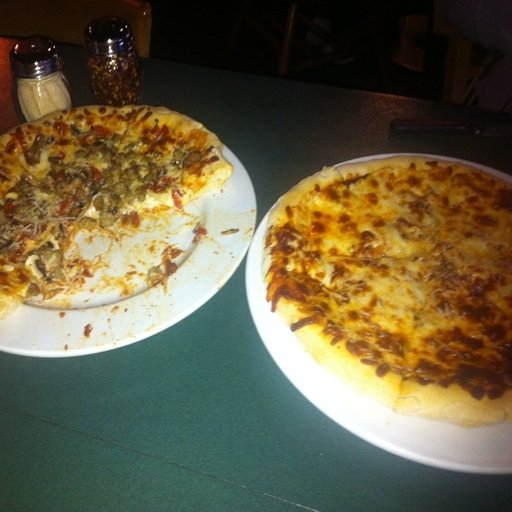

In [20]:
Image.open(train_data.samples[0][0]) # sample image

In [21]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor: {img}")
print(f"Image Shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"image label: {label}")
print(f"label datatype: {type(label)}")

Image Tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image Permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

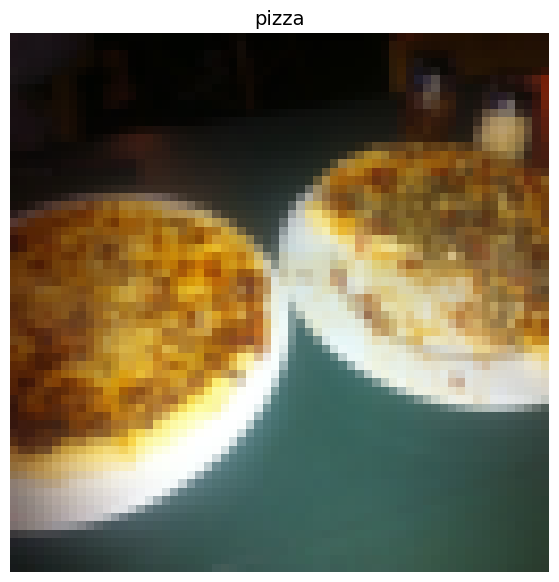

In [22]:
# Plot: Matplotlib ~ HWC -> color channel last
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image Permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

#### 7.2 `DataLoader`

```python
from torch.utils.data import DataLoader
```

A `DataLoader` help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

1. **Data Preparation**: The DataLoader helps you standardize these processes, making your code more readable and maintainable.

2. **Batching**: It allows you to define how many training or testing samples to use in a single iteration. Working with batches of data makes training and testing more manageable.

3. **Shuffling**: DataLoader can shuffle data for you as it loads batches. This increases dataset representativeness and prevents accidental `skewness`.

4. **Multi-processing**: PyTorch optimizes running multiple processes at once, utilizing modern `CPUs` and `GPUs`. DataLoader lets you define how many workers should go at once.

5. **Merging Datasets**: Optionally, you can merge multiple datasets together using DataLoader.

6. **Direct Loading on CUDA**: If you’re using a GPU, DataLoader can load data directly onto CUDA tensors.

In [23]:
# Checking the number of avalible core
import os
os.cpu_count()

2

In [24]:
# Turn the train test datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=2, # available cores for parallel data loading
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=2,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c09f06a3400>,
 <torch.utils.data.dataloader.DataLoader at 0x7c09f06a3a30>)

In [25]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, we can change the batch size
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### **8. Loading Dataset ~ `Option-2`**

**Loading Image Data with a `Custom` Dataset Function**

- **Desired functionality for custom function:**
    - load images from file.
    - get `class names` from the Dataset.
    - get `classes as dictionary` from the Dataset.

- **Pros**
    - Can create the `dataset` out of almost anything.
    - For complex datasets, custom classes can allow for optimizations like caching or lazy loading mechanisms, which might not be feasible with simpler approaches.

- **Cons**
    - Custom code can be prone to errors.
    - Maintenance Overhead: As your dataset or data loading requirements change, you might need to modify the custom class to accommodate those changes

In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### **8.1 Creating a helper function to get class names**

- Uses `os.scandir()` to traverse a target directory (ideally in standard image classification format).
- Extracts `class` names from the directory structure.
- Raises an `error` if no class names are found (indicating potential directory structure issues).
- Creates a dictionary and a list containing the class names.
- Returns the dictionary and list of class names.

---

```python
target_dir = train_dir
print(f"Target directory: {target_dir}")

# Step 1: Scan the target directory
entries = os.scandir(target_dir)

# Step 2: Iterate through the entries and print their details
for entry in entries:
    print(f"Name: {entry.name}, Path: {entry.path}, Is File: {entry.is_file()}, Is Dir: {entry.is_dir()}")
```

```
Target directory: data\pizza_steak_sushi\train
Name: pizza, Path: data\pizza_steak_sushi\train\pizza, Is File: False, Is Dir: True
Name: steak, Path: data\pizza_steak_sushi\train\steak, Is File: False, Is Dir: True
Name: sushi, Path: data\pizza_steak_sushi\train\sushi, Is File: False, Is Dir: True
```

---

```python
# Scans the directory specified by target_dir and returns an iterator of os.DirEntry objects.
entries = os.scandir(target_dir)
# Converts the iterator into a list of os.DirEntry objects.
entry_names = [entry.name for entry in entries]
# Sorts the list of names in alphabetical order.
sorted_entry_names = sorted(entry_names)
# Stores the sorted list of entry names.
sorted_entry_names
```

```
['pizza', 'steak', 'sushi']
```
---

In [29]:
target_dir = train_dir
print(f"Target directory: {target_dir}")

print(list(os.scandir(target_dir)))

class_name = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_name

Target directory: data/pizza_steak_sushi/train
[<DirEntry 'steak'>, <DirEntry 'pizza'>, <DirEntry 'sushi'>]


['pizza', 'steak', 'sushi']

```python
import os
from typing import List, Dict, Tuple

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"classes not found in {directory}")
    # 3. Create a dict of index labels(as computer prefer number over str labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

# Example usage
if __name__ == "__main__":
    try:
        classes, class_indices = find_classes(train_dir)
        print("Classes:", classes)
        print("Class Indices:", class_indices)
    except FileNotFoundError as e:
        print(e)
```

```
find_classes(train_dir)
```

#### **8.2 Create a coustom `Dataset` to replicate `ImageFolder`**

**To create our own custom dataset:**

1. Subclass `torch.utils.data.Dataset`

2. Create  standalone function `find_classes` that can be used by calling `ImageFolderCustom.find_classes(directory)` without creating an instance.

3. `_init_` our subclass with a `target_dir` & then `transform` if we'd like to transform out data.


4. Create several attributes:
   1. `paths`: path to our image
   2. `transform`: The transform we'd like to use.
   3. `classes`: a `list` of target classes.
   4. `class_to_idx`: a `dict` of the target classes mapped to integer labels

5. Create a function to `load_images()`, this functon will open an image.

6. Overwrite the `__len()__` method to return the length of our dataset.

7. Overwrite the `__getitem()__` method to return the given sample when passed as index.

In [30]:
from typing import List, Dict, Tuple
from pathlib import Path
import os
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

#  1. Subclass torch.utils.data.Dataset-----------------------------------------
class ImageFolderCustom(Dataset):
    # These static methods don't need an instance of the class (self).
    # They can be called directly on the class itself.
    @staticmethod
    def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
        """
        Finds classes in a directory and creates a mapping of class names to integer labels.
        Args:
            directory (str): Path to the directory containing class subdirectories.
        Returns:
            Tuple[List[str], Dict[str, int]]: Tuple containing a list of classes and a mapping of class names to integer labels.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Class not found {directory}")
        class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
        return classes, class_to_idx

    # 2. Initialize our custom dataset------------------------------------------
    def __init__(self,
                 target_dir: str,
                 transform: transforms.Compose=None):
        """
        Custom dataset class for loading images from a directory.
        Args:
            target_dir (str): Path to the directory containing image files.
            transform (transforms.Compose, optional): A torchvision transform to apply to the image data.
        """
        self.paths = list(Path(target_dir).glob("*/*.jpg"))  # Get all of the image paths
        self.transform = transform
        self.classes, self.class_to_idx = self.find_classes(target_dir)

    # 4. Create a function to load images-----------------------------------
    def load_image(self, index: int) -> Image.Image:
        """
        Opens an image from a given index and returns it.
        Args:
            index (int): Index of the image in the dataset.
        Returns:
            Image.Image: The loaded image.
        """
        image_path = self.paths[index]
        return Image.open(image_path)


    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.
        Returns:
            int: Length of the dataset.
        """
        return len(self.paths)

    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Returns one sample of data given an index.
        Args:
            index (int): Index of the sample to retrieve.
        Returns:
            tuple: Tuple containing the transformed image and its label.
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name  # format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return untransformed image and label

In [31]:
img, label = train_data[0]
print(img, label)

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [32]:
# Create a transform
from torchvision import transforms

train_transform = transforms.Compose([         # Write a transform for image
    transforms.Resize(size=(64, 64)),          # Resize our images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),    # Flip the images randomly on the horizontal ~ prob 50% i.e img transfrom 50% of time
    transforms.ToTensor()                      # Turn the image into a torch.Tensor
])

test_transfrom = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [33]:
# Test out ImageFolderCoustom
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                     transform=test_transfrom)

In [34]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c09e9c13f10>,
 <__main__.ImageFolderCustom at 0x7c09e9c111b0>)

In [35]:
len(train_data), len(test_data)

(225, 75)

In [36]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [37]:
train_data_custom.find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [38]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


#### **8.3 Create a function to display random images**

1. **Input Parameters**:

    - The function should take in the following parameters:
        - `dataset`: The input dataset (e.g., a NumPy array or a PyTorch dataset).
        - `class_names`: A list of class names corresponding to the dataset.
        - `num_images`: The number of images to visualize (default is 10).
        - `random_seed`: A random seed for reproducibility (default is 42).

2. **Random Sampling**:
    - Generate a list of random sample indexes from the target dataset. You can use NumPy’s `np.random.choice()` function.

3. **Matplotlib Setup**:
    - Create a Matplotlib plot to display the images. Set the figure size appropriately (e.g., `fig, axes = plt.subplots(1, num_images, figsize=(16, 8))`).

4. **Loop and Plot**:
    - Loop through the random sample indexes and plot each image using Matplotlib.
    - Make sure the dimensions of the images align with Matplotlib (HWC format).

5. **Display**:
    - Show the plot using `plt.show()`.



In [39]:
import torch
import random
from typing import List
import matplotlib.pyplot as plt

# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         num_image: int = 10,          # Default number is 10
                         display_shape: bool = True,
                         seed: int = None):

    # 2. Adjust display if num_image is too high
    if num_image > 10:
        num_image = 10        # Setting it to 10
        display_shape = False # Removing shape display
        print("For display purposes, num_image shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set the seed for reproducibility
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=num_image) # k ~ sample size
    print(f"Random sample indexes: {random_sample_idx}")

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through the random sample indexes and plot them with matplotlib
    for i, sample_idx in enumerate(random_sample_idx):
        img, label = dataset[sample_idx][0], dataset[sample_idx][1] # Fix to correctly get image and label
        img_adjust = img.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

        # Plot adjusted sample
        plt.subplot(1, num_image, i + 1)
        plt.imshow(img_adjust)
        plt.axis("off")

        if classes:
            title = f"Class: {classes[label]}"
            if display_shape:
                title += f"\nshape: {img_adjust.shape}"
            plt.title(title)
        else:
            if display_shape:
                plt.title(f"Shape: {img_adjust.shape}")

    plt.show()

Random sample indexes: [62, 57, 35, 188, 26]


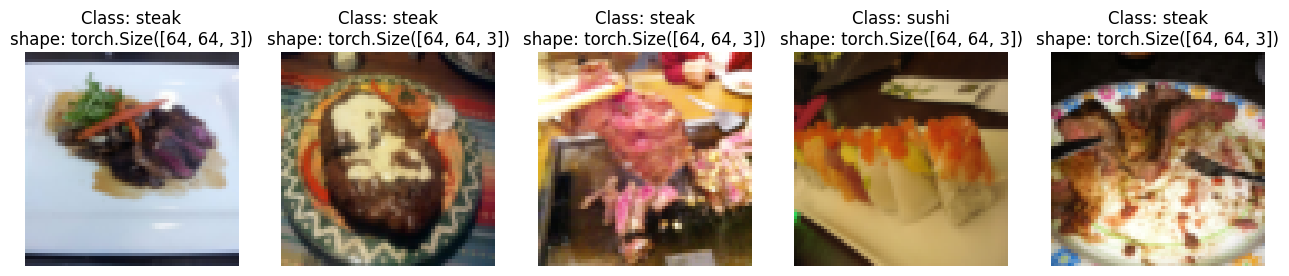

In [40]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      num_image=5,
                      classes=class_names,
                      seed=None)

#### **8.4 Turn custom loaded images into `DataLoader's`**

In [41]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c09e9bdb130>,
 <torch.utils.data.dataloader.DataLoader at 0x7c09e9bf6500>)

In [42]:
# # Get the image and label from custom dataloader
# img_custom, label_custom = next(iter(train_dataloader_custom))

# img_custom.shape, label_custom.shape

### **9. Data augmentation(Other forms of transforms)**

- The process of adding diversity artificially to our training dataset.
- Results in more generalizable to unseen data.

[`trivailaugment`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)

In [43]:
# Let's look at trivailaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])

test_transfrom = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
    ])

In [44]:
image_path

PosixPath('data/pizza_steak_sushi')

In [45]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/2013535.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1598345.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/443210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1647351.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/225990.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614189.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2878151.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2707522.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1761285.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/339891.jpg')]

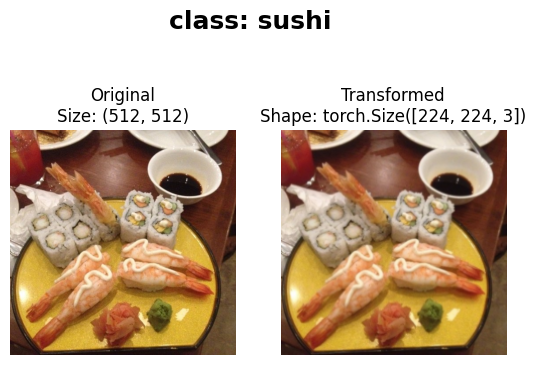

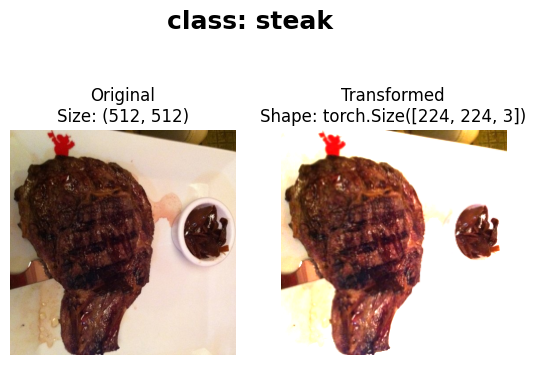

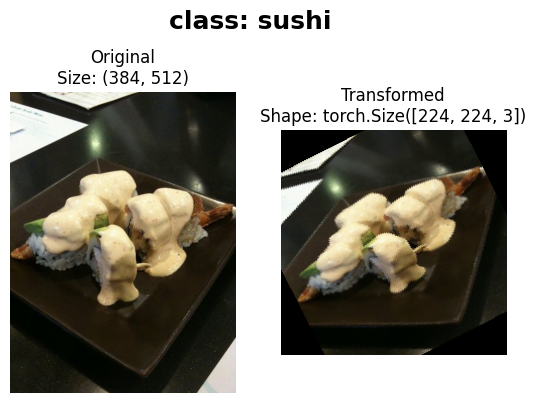

In [46]:
# Plot random transformed images
plot_transformed_images(
    image_path=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

### **10. `TinyVGG` Without Data Augmentation**

#### 10.1 **`Model 0`**

⭐[CNN Explainer](https://poloclub.github.io/cnn-explainer/)

In [47]:
import os
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Simple transformation pipeline for image preprocessing------------------------
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor()              # Convert images to PyTorch tensors
])

# Load and transform data-------------------------------------------------------
train_data_simple = ImageFolder(
    root=train_dir,                    # Directory containing training images
    transform=simple_transform         # Apply the defined transformations
)

test_data_simple = ImageFolder(
    transform=simple_transform,         # Apply the same transformations as for training data
    root=test_dir,                     # Directory containing test images
)

# Define batch size and number of workers for data loading----------------------
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader for training data
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,  # Dataset to load from
    batch_size=BATCH_SIZE,      # Number of samples per batch
    num_workers=NUM_WORKERS,    # Number of subprocesses to use for data loading
    shuffle=True                # Shuffle the data at every epoch
)

# Create DataLoader for test data
test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

# Define the TinyVGG model class------------------------------------------------
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()  # Invoke the constructor of the parent class (nn.Module)

        # Define the first convolutional block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the second convolutional block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the classifier block
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the input tensor
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape),  # Fully connected layer
        )

    # Define the forward pass
    def forward(self, x):
        x = self.conv_block_1(x)  # Pass input through the first convolutional block
        x = self.conv_block_2(x)  # Pass input through the second convolutional block
        x = self.classifier(x)    # Pass input through the classifier
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [48]:
# Modeling the instance of clas-------------------------------------------------
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [49]:
# Get a single image batch
img, label = next(iter(train_dataloader_simple))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
# try forward pass
model_0(img.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

**`torchinfo`**

In [51]:
!pip -q install torchinfo

In [52]:
import torchinfo
from torchinfo import summary

summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

#### **10.2 Create train and test loops functions**

- `train_step()` - Takes the model and dataloader and train the model on the dataloader.
- `test_step()` - Takes the model and dataloader and test the model on the dataloader.


```python
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Create accuracy function------------------------------------------------------
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Create the train_step()-------------------------------------------------------
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: accuracy_fn,
               device: torch.device = device)

    # Put the model in the training mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # loop through the dataloader data batches
    for batch, (X, y) in  enumerate(dataloader):
        # Send the data to the target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass(output the raw logits from the model)
        y_pred = model(X)
        
        # 2. Calculating the loss and accuracy(per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=torch.argmax(y_pred, dim=1))
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()

    # Adjust metric to get average loss and accuracy per batch
    # Divide total train loss and accuracy by length of dataloader
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


# Create the test_step()--------------------------------------------------------
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: accuracy_fn,
              device: torch.device = device):
    
    # Put the model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on the inference mode
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send the data to devide
            X, y = X.to(device), y.to(device)

            # 1. Forward pass(output the raw logits)
            test_pred = model(X)

            # 2. Calculate the loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss.item
            test_acc += accuracy_fn(y_true=y, y_pred=torch.argmax(test_pred, dim=1))

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc
```   

In [53]:
# Create train_step()----------------------------------------------------------
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)  # output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Apply softmax to get probabilities for each class, then get the class index with the highest probability
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

        # Calculate accuracy by comparing predicted class indices with true labels
        # (y_pred_class == y) returns a tensor of boolean values where the predictions are correct
        # .sum().item() counts the number of correct predictions
        # / len(y_pred) normalizes by the number of predictions to get accuracy
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


# Create a test step()----------------------------------------------------------
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0,  0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Get the predicted class indices by finding the index with the highest logit (score) for each input
            test_pred_labels = test_pred_logits.argmax(dim=1)

            # Calculate accuracy by comparing predicted class indices with true labels
            # (test_pred_labels == y) returns a tensor of boolean values where the predictions are correct
            # .sum().item() counts the number of correct predictions
            # / len(test_pred_labels) normalizes by the number of predictions to get accuracy
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

#### **10.3 Creating a `train()` function to combine `train_step()` and `test_step()`**

In [54]:
from tqdm.auto import tqdm

# 1. Create a train function that take in various model parameter + optimizer + dataloader + loss funciton
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # 3. Loop through training and testing steps for number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                         dataloader=test_dataloader,
                                         loss_fn=loss_fn,
                                         device=device)

        # 4. Print out what's happening
        if epoch%10 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

#### **10.4 Train and evaluate `model_0`**

In [55]:
# set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
EPOCHS = 100

# Recreate the instance of TinyVGG
model_0 = TinyVGG(input_shape=3,  # Number of color channels of out target image
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)


# start the Timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS)

# End the Timer
end_timer = timer()
print(f"Total train time: {(end_timer - start_time):.3f} sec")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 10 | Train loss: 0.8699 | Train acc: 0.5195 | Test loss: 0.9761 | Test acc: 0.4830
Epoch: 20 | Train loss: 0.7844 | Train acc: 0.6172 | Test loss: 1.0995 | Test acc: 0.4943
Epoch: 30 | Train loss: 0.6607 | Train acc: 0.7930 | Test loss: 1.0543 | Test acc: 0.5161
Epoch: 40 | Train loss: 0.7024 | Train acc: 0.6562 | Test loss: 1.1910 | Test acc: 0.4451
Epoch: 50 | Train loss: 0.5056 | Train acc: 0.8203 | Test loss: 1.3714 | Test acc: 0.5152
Epoch: 60 | Train loss: 0.5220 | Train acc: 0.7695 | Test loss: 1.6837 | Test acc: 0.4328
Epoch: 70 | Train loss: 0.3898 | Train acc: 0.8555 | Test loss: 1.8357 | Test acc: 0.4233
Epoch: 80 | Train loss: 0.2523 | Train acc: 0.8359 | Test loss: 2.1893 | Test acc: 0.4943
Epoch: 90 | Train loss: 0.0711 | Train acc: 0.9883 | Test loss: 2.7858 | Test acc: 0.4545
Total train time: 201.079 sec


- Train Time CPU(`epoch=100`) $\rightarrow$  `198.310` sec
- Train Time GPU(`epoch=100`) $\rightarrow$  `112.959` sec

#### **10.5 Plot the loss curves of `Model_0`**

In [56]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844,
  1.0305050686001778,
  0.9854370653629303,
  0.9662912264466286,
  0.9238169267773628,
  0.9969005659222603,
  0.8698794320225716,
  0.9240578711032867,
  0.7841039318591356,
  0.9045028984546661,
  0.789142481982708,
  0.7492810562252998,
  0.7733712382614613,
  0.7480174712836742,
  0.7749622315168381,
  0.7755447328090668,
  0.7844467312097549,
  0.7869665324687958,
  0.7322786599397659,
  0.8699127808213234,
  0.6531565133482218,
  0.7044287100434303,
  0.6315567307174206,
  0.6560348756611347,
  0.6014471943490207,
  0.7655341327190399,
  0.6606595367193222,
  0.5743622509762645,
  0.5757075883448124,
  0.5709167383611202,
  0.5547012519091368,
  0.5703363064676523,
  0.5946025587618351,
  0.6467064097523689,
  0.672199510037899,
  0.5825753547251225,
  0.7023898549377918,
  0.6265740841627121,
  0.6582956910133362,
  0.6485462933778763,
  0.7044902220368385,

In [57]:
num_epoch = len(model_0_results["train_loss"])
num_epoch

100

In [58]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [59]:
def loss_plot_curves(results: Dict[str, List[float]]):
    # Get the loss and accuracy values of the results dictionary
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Epochs
    epochs = range(len(results["train_loss"]))

    # Plots
    plt.figure(figsize=(15, 7))

    # Loss
    plt.subplot(1, 2, 1) # Row->1, Col->2, idx->1
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2) # Row->1, Col->2, idx->2
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

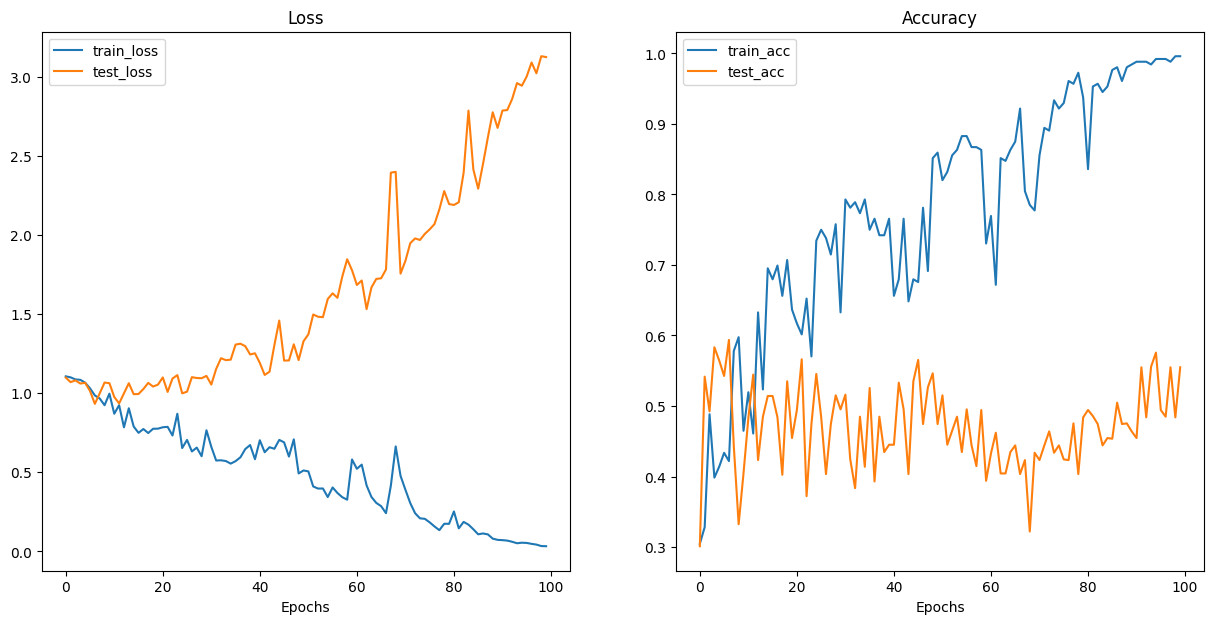

In [60]:
loss_plot_curves(model_0_results)

### **11. `TinyVGG` With Data Augmentation**

#### **11.1 `Model_1`**

In [61]:
import os
import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from timeit import default_timer as timer

# set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Data Transform with TriviailAugment-------------------------------------------
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# ImageFolder -> dataset--------------------------------------------------------
train_data_argumented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                             transform=test_transform_simple)


# Dataset -> DataLoader---------------------------------------------------------
BATCH_SIZE =32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_argumented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=False)


# Create Model_1 and sent it to Target Device
model_1 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

print(model_0)
print("-"*70)

# Setup Loss and Optimizer------------------------------------------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Train and evaluate------------------------------------------------------------
NUM_EPOCHS = 100

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()

print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)
----------------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1069 | Train acc: 0.3047 | Test loss: 1.0993 | Test acc: 0.2708
Epoch: 10 | Train loss: 1.0539 | Train acc: 0.4844 | Test loss: 1.0191 | Test acc: 0.5227
Epoch: 20 | Train loss: 0.9451 | Train acc: 0.6172 | Test loss: 0.9894 | Test acc: 0.4129
Epoch: 30 | Train loss: 0.9172 | Train acc: 0.5898 | Test loss: 0.9421 | Test acc: 0.4545
Epoch: 40 | Train loss: 0.9394 | Train acc: 0.5195 | Test loss: 1.0047 | Test acc: 0.4460
Epoch: 50 | Train loss: 0.8939 | Train acc: 0.6328 | Test loss: 0.9590 | Test acc: 0.4025
Epoch: 60 | Train loss: 0.8923 | Train acc: 0.5000 | Test loss: 1.0141 | Test acc: 0.4460
Epoch: 70 | Train loss: 0.9722 | Train acc: 0.5273 | Test loss: 1.1869 | Test acc: 0.3816
Epoch: 80 | Train loss: 0.8319 | Train acc: 0.6328 | Test loss: 1.0299 | Test acc: 0.4754
Epoch: 90 | Train loss: 0.9364 | Train acc: 0.5156 | Test loss: 1.0535 | Test acc: 0.3731
Total training time for model_1: 182.209 seconds


#### **11.2 Plot the loss curves of `model_1`**

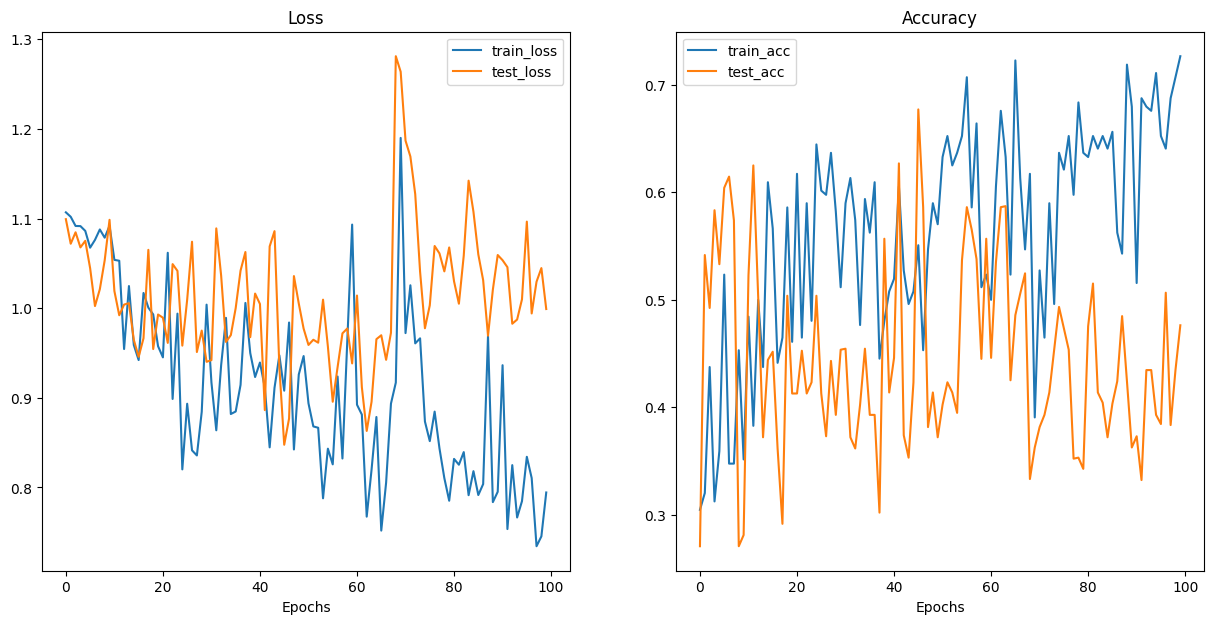

In [62]:
loss_plot_curves(model_1_results)

####  **11.3 Compare model results**

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:

1. **Hard coding** (what we're doing)
2. [**PyTorch + Tensorboard**](https://pytorch.org/docs/stable/tensorboard.html)
3. [**Weights & Biases**](https://wandb.ai/site/experiment-tracking](https://wandb.ai/site/experiment-tracking)
4. [**MLFlow**](https://mlflow.org/)


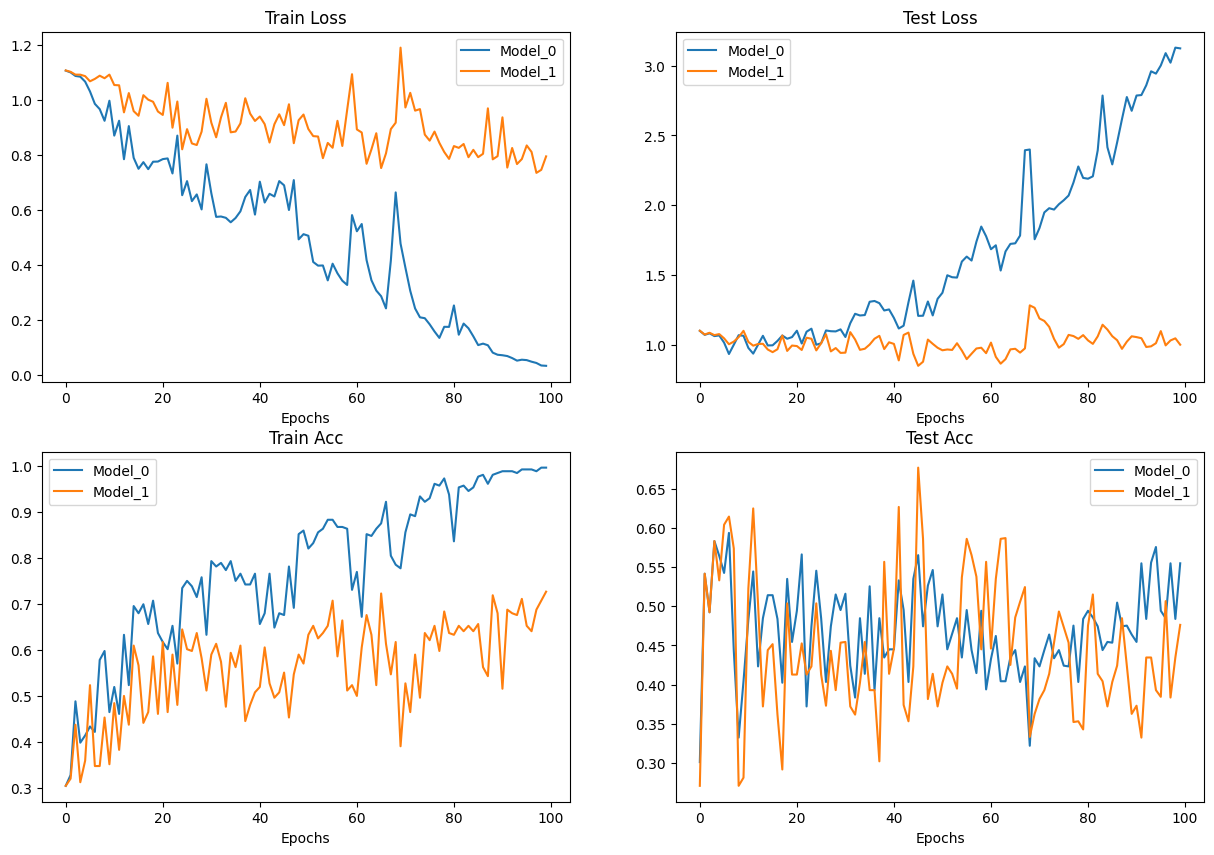

In [63]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

# Plot
plt.figure(figsize=(15, 10))

# get the number of epochs
epochs = range(len(model_0_df))

# Train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model_0")
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model_0")
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Train Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model_0")
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Test Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model_0")
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

### **12. Making a prediction on a custom image**

In [78]:
import requests
from pathlib import Path

# Set up the path
image_path = Path("custom_img")
image_path.mkdir(parents=True, exist_ok=True)

# Setup the image path for the custom image
custom_img_path = image_path / "pizza_sample.jpg"

url = "https://raw.githubusercontent.com/mohd-faizy/PyTorch-Essentials/main/data/pizza_sample.jpg"

# Download the image if it doesn't already exist
if not custom_img_path.is_file():
    with open(custom_img_path, "wb") as f:
        response = requests.get(url)
        print(f"Downloading {custom_img_path}...")
        f.write(response.content)
else:
    print(f"{custom_img_path} already exists...")

custom_img/pizza_sample.jpg already exists...


**We have to make sure our custom image is in the same format as the data our model was trained on.**

- In tensor form with datatype (`torch.float32`)
- Of shape `64x64x3`
- On the right `device`

In [84]:
import torchvision

# Read custom image
custom_img_uint8 = torchvision.io.read_image(str(custom_img_path))
print((f"Custom image Tensor:\n {custom_img_uint8}"))
print((f"Custom image Shape:\n {custom_img_uint8.shape}"))
print((f"Custom image Datatype:\n {custom_img_uint8.dtype}"))

Custom image Tensor:
 tensor([[[126, 123, 121,  ...,  64,  65,  65],
         [123, 121, 119,  ...,  60,  66,  66],
         [120, 118, 116,  ...,  56,  68,  68],
         ...,
         [ 74,  66,  62,  ...,  28,  15,  33],
         [ 84,  69,  59,  ...,  33,  43,  63],
         [ 96,  72,  56,  ...,  39,  31,  53]],

        [[126, 123, 121,  ...,  65,  66,  66],
         [123, 121, 119,  ...,  61,  67,  67],
         [120, 118, 116,  ...,  57,  69,  69],
         ...,
         [ 74,  66,  62,  ...,  28,  15,  33],
         [ 84,  69,  59,  ...,  33,  43,  63],
         [ 96,  72,  56,  ...,  39,  31,  53]],

        [[134, 131, 129,  ...,  67,  68,  68],
         [131, 129, 127,  ...,  63,  69,  69],
         [128, 126, 124,  ...,  59,  71,  71],
         ...,
         [ 82,  74,  70,  ...,  30,  17,  35],
         [ 92,  77,  67,  ...,  35,  45,  65],
         [104,  80,  64,  ...,  41,  33,  55]]], dtype=torch.uint8)
Custom image Shape:
 torch.Size([3, 315, 474])
Custom image Datat

>The `torch.uint8` data type in **PyTorch** represents an `8-bit` unsigned integer. It’s commonly used for **storing pixel values** in images or other scenarios where values range from 0 to 255.

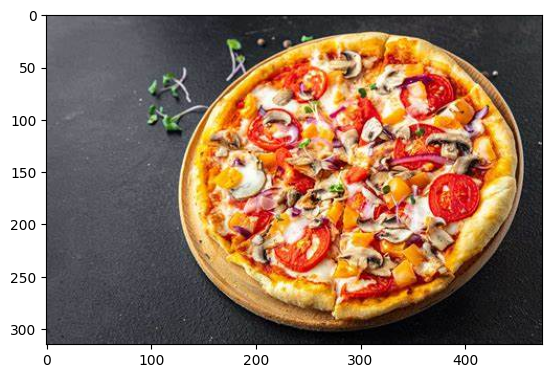

In [85]:
plt.imshow(custom_img_uint8.permute(1, 2, 0));

#### **`RuntimeError #1`**
```python
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image).to(device)
```
```python
RuntimeError: Input type (unsigned char) and bias type (float) should be the same
```

##### **`FIX#1`**

**convert** ~ `torch.uint8` ⇒ `torch.float32`

In [87]:
custom_image = torchvision.io.read_image(str(custom_img_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.4941, 0.4824, 0.4745,  ..., 0.2510, 0.2549, 0.2549],
         [0.4824, 0.4745, 0.4667,  ..., 0.2353, 0.2588, 0.2588],
         [0.4706, 0.4627, 0.4549,  ..., 0.2196, 0.2667, 0.2667],
         ...,
         [0.2902, 0.2588, 0.2431,  ..., 0.1098, 0.0588, 0.1294],
         [0.3294, 0.2706, 0.2314,  ..., 0.1294, 0.1686, 0.2471],
         [0.3765, 0.2824, 0.2196,  ..., 0.1529, 0.1216, 0.2078]],

        [[0.4941, 0.4824, 0.4745,  ..., 0.2549, 0.2588, 0.2588],
         [0.4824, 0.4745, 0.4667,  ..., 0.2392, 0.2627, 0.2627],
         [0.4706, 0.4627, 0.4549,  ..., 0.2235, 0.2706, 0.2706],
         ...,
         [0.2902, 0.2588, 0.2431,  ..., 0.1098, 0.0588, 0.1294],
         [0.3294, 0.2706, 0.2314,  ..., 0.1294, 0.1686, 0.2471],
         [0.3765, 0.2824, 0.2196,  ..., 0.1529, 0.1216, 0.2078]],

        [[0.5255, 0.5137, 0.5059,  ..., 0.2627, 0.2667, 0.2667],
         [0.5137, 0.5059, 0.4980,  ..., 0.2471, 0.2706, 0.2706],
         [0.5020, 0.4941, 0.4863,  ..., 0.2314, 0.2784, 0.

#### **`RuntimeError #2`**
```python
model_1.eval()
with torch.inference_mode():
    model_1(custom_image).to(device)
```
```python
RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x8625 and 1690x3)
```

##### **`FIX#2`**

**Shape** ~ `torch.Size([3, 315, 474])` ⇒ `torch.Size([3, 64, 64])`

In [92]:
# Create the transform pipeline to resize the image
from torchvision import transforms

custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

# Transfrom the target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 315, 474])
Transformed shape: torch.Size([3, 64, 64])


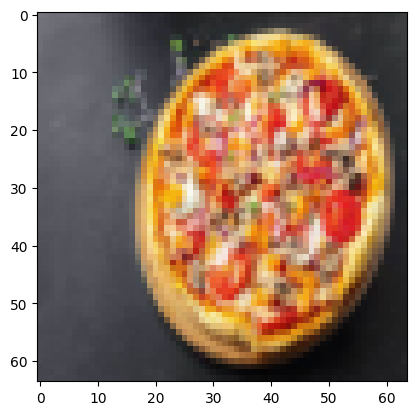

In [93]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

#### **`RuntimeError #3`**

```python
# This will error: image not on right device
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)
```

```python
RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)
```

##### **`FIX#3`**

- `.to(device)`

```python
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))
```

```python
RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)
```

🔴 **This will error :** `no batch size`


In [96]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

##### **`FIX#4`**

In [97]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [99]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0)).to(device)

custom_image_pred

tensor([[ 1.2223, -2.9762,  0.0421]])

**Note, to make a prediction on a custom image we had to:**

- Load the image and turn it into a **tensor**
- Make sure the image was the **same datatype** as the model (`torch.float32`)
- Make sure the image was the **same shape** as the data the model was trained on `(3, 64, 64)` with a batch size... `(1, 3, 64, 64)`.
- Make sure the image was on the **same device** as our model

In [104]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(custom_image_pred_probs)

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
print(custom_image_pred_label)

tensor([[0.7563, 0.0114, 0.2323]])
tensor([0])


### **13. Putting custom image prediction together: building a function**

In [112]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
    """Makes a prediction on a target image with a trained model and plots the image and prediction."""
    # Load in the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on the target device
    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
        target_image = target_image.unsqueeze(0)

        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

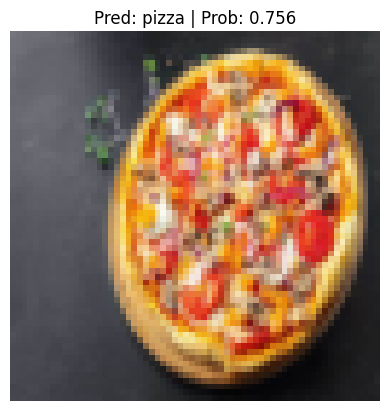

In [114]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_img_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)